# **NDD Perturb-seq project**
### Preprocessing iNeuron or iPSC data and assigning gRNAs from CLEANSER output

### Importing packages

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

### Importing raw H5 data for iNeurons or iPSCs

In [3]:
adata = sc.read_10x_h5("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/filtered_feature_bc_matrix.h5", gex_only=False)

/home/toofastdan/apps/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
#adata = sc.read_mtx("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/batch1/matrix.mtx.gz")
#adata.obs_names = np.loadtxt("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/batch1/barcodes.tsv.gz", dtype=str, delimiter="\t")
#var = np.loadtxt("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/batch1/features.tsv.gz", dtype=str, delimiter="\t")
#adata.var_names = var[:,0]

In [4]:
adata

AnnData object with n_obs × n_vars = 450370 × 40774
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'

In [5]:
adata.var["feature_types"].unique()

array(['Gene Expression', 'CRISPR Guide Capture'], dtype=object)

## CellRanger: Importing protospacer calls per cell to determine which cells got which gRNAs

In [ ]:
# iNeurons or iPSCs
grna_calls = pd.read_csv("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/protospacer_calls_per_cell.csv")

In [7]:
num_grna_calls = grna_calls["num_features"].value_counts().reset_index()
num_grna_calls

,num_features,count
0,1,114480
1,2,43983
2,3,14202
3,4,4572
4,5,1702
5,6,755
6,7,369
7,8,236
8,9,150
9,10,88


### Plotting the distribution of cells and the gRNA counts

In [8]:
# Value counts
num_grna_calls = grna_calls["num_features"].value_counts().reset_index()

# Grouping all cells with >5 gRNAs per cell
num_5_grna_calls = num_grna_calls[num_grna_calls["num_features"]>5].sum()
num_5_grna_calls

# Making a plottable dataframe
num_grna_calls = num_grna_calls[num_grna_calls["num_features"]<5]
num_grna_calls.loc[len(num_grna_calls)] = [0, adata.n_obs - grna_calls.shape[0]]
num_grna_calls.loc[len(num_grna_calls)] = [">5", num_5_grna_calls["count"]]
category_types = CategoricalDtype(categories=["0", "1", "2", "3", "4", ">5"], ordered=True)
num_grna_calls["num_features"] = num_grna_calls["num_features"].astype(str).astype(category_types)
num_grna_calls

,num_features,count
0,1,114480
1,2,43983
2,3,14202
3,4,4572
4,0,27382
5,>5,1923


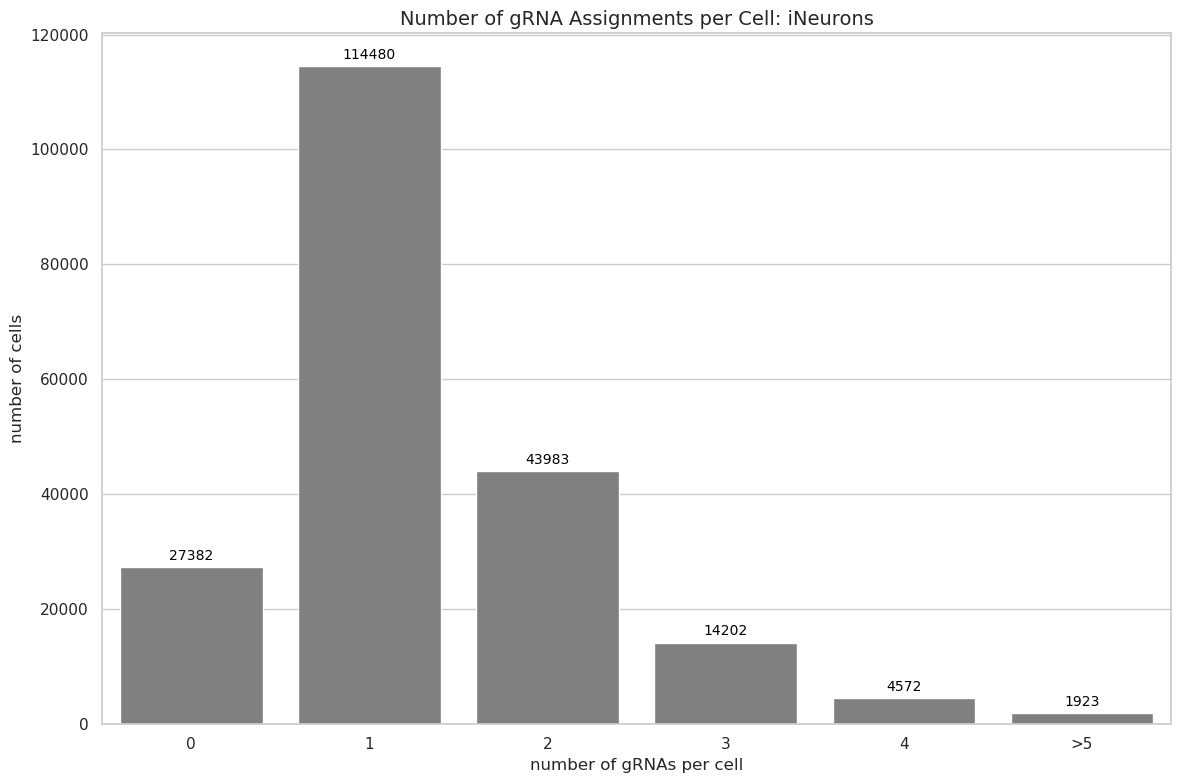

In [9]:
# Set style
sns.set(style="whitegrid")

# Create a barplot for gRNA count distribution per cell
plt.figure(figsize=(12,8))
ax = sns.barplot(x="num_features", y="count", data=num_grna_calls, color="grey")

# Adding labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')

# Labels and title
ax.set_xlabel("number of gRNAs per cell", fontsize=12)
ax.set_ylabel("number of cells", fontsize=12)
ax.set_title("Number of gRNA Assignments per Cell: iNeurons", fontsize=14)

plt.tight_layout()

# Exporting the plot
#plt.savefig("iNeuron_figures/guide_counts_histogram.png", dpi=300)

# Showing the plot
plt.show()

## CLEANSER: Importing protospacer calls per cell to determine which cells got which gRNAs

In [2]:
cleanser_calls = pd.read_csv("CLEANSER/iNeuron_posteriors-output", sep="\t", header=None, skiprows=1)
cleanser_calls.columns = ["gRNA", "cell", "posterior_probability"]
cleanser_calls

,gRNA,cell,posterior_probability
0,38607,100273,0.004182
1,38607,100489,1.000000
2,38607,101256,0.003253
3,38607,101618,0.008155
4,38607,101754,0.001519
...,...,...,...
15635115,40774,97709,1.000000
15635116,40774,98663,0.001206
15635117,40774,98767,0.001585
15635118,40774,99071,0.001206


In [ ]:
# Optional display in excel
#cleanser_calls_small = cleanser_calls.iloc[1:10, :]
#cleanser_calls_small.to_excel("CLEANSER/example_posteriors_output.xlsx", index=False)

In [6]:
# Getting a list of gRNAs per cell
features = pd.DataFrame(adata.var).reset_index()
features = features[["index", "gene_ids", "feature_types"]]
features["gRNA"] = np.arange(1, features.shape[0] + 1)
features = features[features["feature_types"]=="CRISPR Guide Capture"]
features.columns = ["gRNA_id", "gRNA_name", "feature_types", "gRNA"]
cleanser_posterior = pd.merge(cleanser_calls, features, on="gRNA", how="left")

# Merging with cell barcodes for CRISPR guides
crispr_adata = adata[:, adata.var['feature_types'] == 'CRISPR Guide Capture']
barcode_df = pd.DataFrame({
    'cell': range(len(crispr_adata.obs_names)),
    'cell_barcode': crispr_adata.obs_names
})
barcode_df["cell"] = barcode_df["cell"] + 1
cleanser_posterior = pd.merge(cleanser_posterior, barcode_df, on="cell", how="left")
cleanser_posterior

,gRNA,cell,posterior_probability,gRNA_id,gRNA_name,feature_types,cell_barcode
0,38607,100273,0.004182,GRN-g1,GRN-g1,CRISPR Guide Capture,GCTTGCTGTATCTGGG-2
1,38607,100489,1.000000,GRN-g1,GRN-g1,CRISPR Guide Capture,GGAAAGGCACTGGCAC-2
2,38607,101256,0.003253,GRN-g1,GRN-g1,CRISPR Guide Capture,GGAGCAGGTAGTCGCA-2
3,38607,101618,0.008155,GRN-g1,GRN-g1,CRISPR Guide Capture,GGATCGCGTGGCATGC-2
4,38607,101754,0.001519,GRN-g1,GRN-g1,CRISPR Guide Capture,GGATTCGGTGGAACCC-2
...,...,...,...,...,...,...,...
15635115,40774,97709,1.000000,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCCTTAGCACGAGCGA-2
15635116,40774,98663,0.001206,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCGTCTACACAAATCC-2
15635117,40774,98767,0.001585,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCGTGTTAGAACGTAA-2
15635118,40774,99071,0.001206,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCTACCTGTCTATTGT-2


In [7]:
# Converting 1-indexing to Python 0-indexing
cleanser_posterior['gRNA_0_idx'] = cleanser_posterior['gRNA'] - 1
cleanser_posterior['cell_0_idx'] = cleanser_posterior['cell'] - 1

# Extracting the counts using these integer positions directly
row_indices = cleanser_posterior['gRNA_0_idx'].values
col_indices = cleanser_posterior['cell_0_idx'].values

# Pulling UMI values from the matrix
# AnnData X is (Cells, Features), so we use [cell_pos, gRNA_pos]
cleanser_posterior['UMI'] = np.asarray(adata.X[col_indices, row_indices]).flatten()
cleanser_posterior

,gRNA,cell,posterior_probability,gRNA_id,gRNA_name,feature_types,cell_barcode,gRNA_0_idx,cell_0_idx,UMI
0,38607,100273,0.004182,GRN-g1,GRN-g1,CRISPR Guide Capture,GCTTGCTGTATCTGGG-2,38606,100272,1.0
1,38607,100489,1.000000,GRN-g1,GRN-g1,CRISPR Guide Capture,GGAAAGGCACTGGCAC-2,38606,100488,176.0
2,38607,101256,0.003253,GRN-g1,GRN-g1,CRISPR Guide Capture,GGAGCAGGTAGTCGCA-2,38606,101255,1.0
3,38607,101618,0.008155,GRN-g1,GRN-g1,CRISPR Guide Capture,GGATCGCGTGGCATGC-2,38606,101617,2.0
4,38607,101754,0.001519,GRN-g1,GRN-g1,CRISPR Guide Capture,GGATTCGGTGGAACCC-2,38606,101753,1.0
...,...,...,...,...,...,...,...,...,...,...
15635115,40774,97709,1.000000,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCCTTAGCACGAGCGA-2,40773,97708,121.0
15635116,40774,98663,0.001206,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCGTCTACACAAATCC-2,40773,98662,1.0
15635117,40774,98767,0.001585,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCGTGTTAGAACGTAA-2,40773,98766,1.0
15635118,40774,99071,0.001206,Non-Targeting-g110,Non-Targeting-g110,CRISPR Guide Capture,GCTACCTGTCTATTGT-2,40773,99070,1.0


In [ ]:
# Optional display in excel
#cleanser_posterior_small = cleanser_posterior.iloc[1:10, :]
#cleanser_posterior_small.to_excel("CLEANSER/example_posteriors_output_with_data.xlsx", index=False)

In [19]:
# Filtering for high-likelihood gRNA calls with posterior probability >= 0.5
cleanser_posterior_filt = cleanser_posterior[cleanser_posterior["posterior_probability"] >= 0.5]
cleanser_posterior_filt["UMI"] = cleanser_posterior_filt["UMI"].astype(int)

# Grouping and summarizing how many UMIs per gRNA per cell
cleanser_posterior_gb = cleanser_posterior_filt.groupby('cell_barcode').agg(
    num_features=('gRNA_name', 'count'),
    feature_call=('gRNA_name', lambda x: "|".join(x.unique().astype(str))),
    num_umis=('UMI', lambda x: "|".join(x.unique().astype(str)))
).reset_index()

# Adding cells with zero counts
all_barcodes = adata.obs_names
called_barcodes = cleanser_posterior_gb["cell_barcode"].values
zero_cells = all_barcodes[~all_barcodes.isin(called_barcodes)]

# Making a dataframe for cells with zero calls
grna_calls_zero = pd.DataFrame({"cell_barcode": zero_cells, "num_features": 0, "feature_call": "None", "num_umis": "0"})

# Binding rows
cleanser_posterior_gb = pd.concat([cleanser_posterior_gb, grna_calls_zero], ignore_index=True)
cleanser_posterior_gb["cell_barcode_num_features_gRNA"] = (cleanser_posterior_gb["cell_barcode"] + "_" + cleanser_posterior_gb["num_features"].astype(str) + "_" + cleanser_posterior_gb["feature_call"])
cleanser_posterior_gb

/tmp/ipykernel_452012/3590817634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanser_posterior_filt["UMI"] = cleanser_posterior_filt["UMI"].astype(int)


,cell_barcode,num_features,feature_call,num_umis,cell_barcode_num_features_gRNA
0,AAACCAAAGAAACGCG-2,1,ZEB2-g18,747,AAACCAAAGAAACGCG-2_1_ZEB2-g18
1,AAACCAAAGAAACTAG-6,1,SET-g8,1359,AAACCAAAGAAACTAG-6_1_SET-g8
2,AAACCAAAGAAAGGAG-6,1,Non-Targeting-g91,26,AAACCAAAGAAAGGAG-6_1_Non-Targeting-g91
3,AAACCAAAGAAAGGAG-8,1,UPF3B-g4,112,AAACCAAAGAAAGGAG-8_1_UPF3B-g4
4,AAACCAAAGAAATGGC-7,1,DNMT3A-g4,66,AAACCAAAGAAATGGC-7_1_DNMT3A-g4
...,...,...,...,...,...
450365,GTTGTGCAGGGCGGAT-8,0,None,0,GTTGTGCAGGGCGGAT-8_0_None
450366,GTTGTGGGTAAGGTAG-8,0,None,0,GTTGTGGGTAAGGTAG-8_0_None
450367,GTTGTGGGTAGAGGCG-8,0,None,0,GTTGTGGGTAGAGGCG-8_0_None
450368,GTTGTGGGTCTGTATT-8,0,None,0,GTTGTGGGTCTGTATT-8_0_None


In [ ]:
# Optional display in excel
#example_barcodes = ["AAATGACCAGCTCCAA-1", "AACCGAACACGCAGGA-1", "AACGTCGGTGGAGCAG-1", "ACATATTCAAAAGCAT-1", "ACCCCGTTCATTATCT-1", "AGGACGGGTGCGCTGG-1", "AGTACTGTCGTAGTCA-1", "AGTGCGAAGCCCTGGA-1", "ATCTCACTCACATCAG-1", "ATCTCTTCACTGACAT-1"]
#cleanser_posterior_gb = cleanser_posterior_gb[cleanser_posterior_gb["cell_barcode"].isin(example_barcodes)]
#cleanser_posterior_gb.to_excel("CLEANSER/example_protospacers.xlsx", index=False)

In [20]:
num_grna_calls_cleanser = cleanser_posterior_gb["num_features"].value_counts().reset_index()
num_grna_calls_cleanser

,num_features,count
0,1,272088
1,2,94512
2,0,42219
3,3,26617
4,4,7183
5,5,2328
6,6,889
7,7,577
8,8,483
9,9,412


### Plotting the distribution of cells and the gRNA counts

In [22]:
# Value counts
num_grna_calls = cleanser_posterior_gb["num_features"].value_counts().reset_index()

# Grouping all cells with >5 gRNAs per cell
num_5_grna_calls = num_grna_calls[num_grna_calls["num_features"]>5].sum()
num_5_grna_calls

# Making a plottable dataframe
num_grna_calls = num_grna_calls[num_grna_calls["num_features"]<5]
num_grna_calls.loc[len(num_grna_calls)] = [0, adata.n_obs - cleanser_posterior_gb.shape[0]]
num_grna_calls.loc[len(num_grna_calls)] = [">5", num_5_grna_calls["count"]]
category_types = CategoricalDtype(categories=["0", "1", "2", "3", "4", ">5"], ordered=True)
num_grna_calls["num_features"] = num_grna_calls["num_features"].astype(str).astype(category_types)
num_grna_calls

,num_features,count
0,1,272088
1,2,94512
2,0,42219
3,3,26617
4,4,7183
5,0,0
6,>5,5423


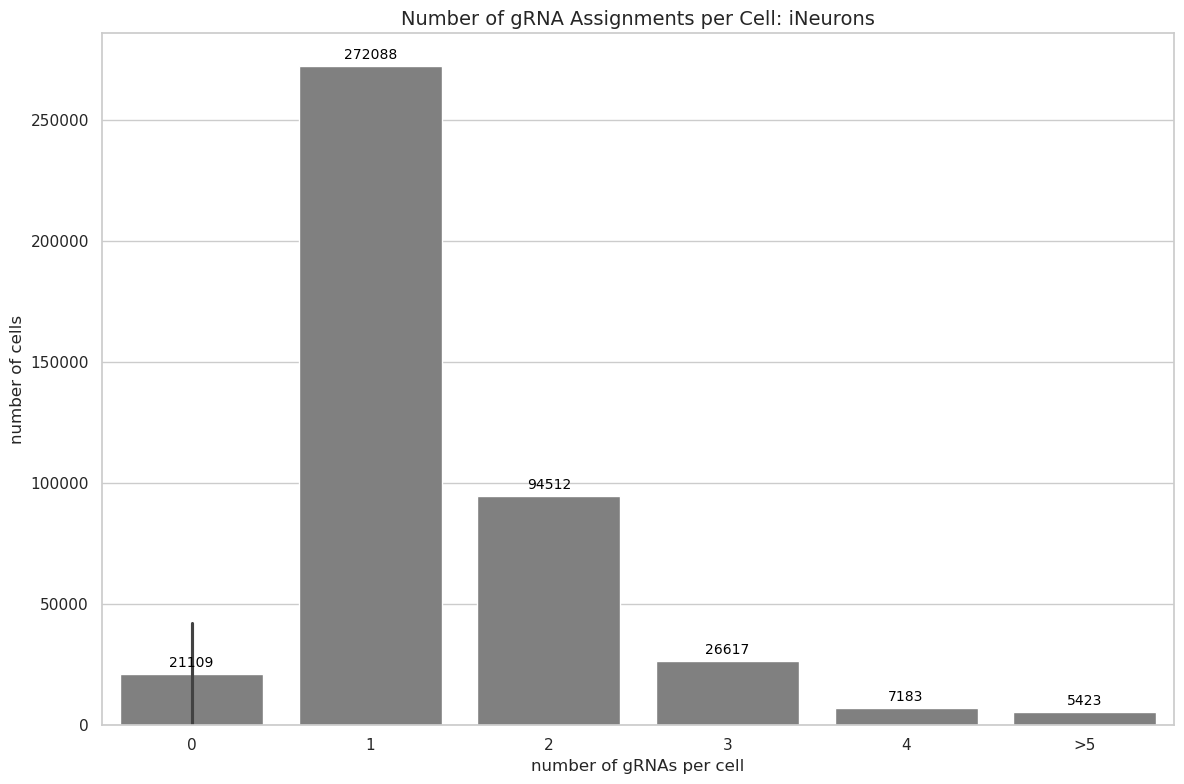

In [ ]:
# Set style
sns.set(style="whitegrid")

# Create a barplot for gRNA count distribution per cell
plt.figure(figsize=(12,8))
ax = sns.barplot(x="num_features", y="count", data=num_grna_calls, color="grey")

# Adding labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')

# Labels and title
ax.set_xlabel("number of gRNAs per cell", fontsize=12)
ax.set_ylabel("number of cells", fontsize=12)
ax.set_title("Number of gRNA Assignments per Cell: iNeurons", fontsize=14)

plt.tight_layout()

# Exporting the plot
#plt.savefig("iNeuron_figures/guide_counts_histogram.pdf", dpi=300)

# Showing the plot
plt.show()

### Adding zero count cells to the Cellranger gRNA calls

In [17]:
# Adding zero count cells to the Cellranger gRNA calls
all_barcodes = adata.obs_names
called_barcodes = grna_calls["cell_barcode"].values
zero_cells = all_barcodes[~all_barcodes.isin(called_barcodes)]

# Making a dataframe for cells with zero calls
grna_calls_zero = pd.DataFrame({"cell_barcode": zero_cells, "num_features": 0, "feature_call": "None", "num_umis": "0"})

# Binding rows
cellranger_grna = pd.concat([grna_calls, grna_calls_zero], ignore_index=True)
cellranger_grna["cell_barcode_num_features_gRNA"] = (cellranger_grna["cell_barcode"] + "_" + cellranger_grna["num_features"].astype(str) + "_" + cellranger_grna["feature_call"])
cellranger_grna

,cell_barcode,num_features,feature_call,num_umis,cell_barcode_num_features_gRNA
0,AAGTCGCTCCGACTCC-1,1,ADAR-g1,87,AAGTCGCTCCGACTCC-1_1_ADAR-g1
1,AATGTGTTCGTAATTA-1,1,ADAR-g1,2032,AATGTGTTCGTAATTA-1_1_ADAR-g1
2,ACAACGCTCCACTACT-1,3,ADAR-g1|ANKRD11-g5|TRRAP-g1,1851|1986|76,ACAACGCTCCACTACT-1_3_ADAR-g1|ANKRD11-g5|TRRAP-g1
3,ACAATGGCAGCTAGGG-1,4,ADAR-g1|NR2F1-g6|SATB1-g9|ZMIZ1-g6,803|155|140|661,ACAATGGCAGCTAGGG-1_4_ADAR-g1|NR2F1-g6|SATB1-g9...
4,ACACCCTGTCACGGCG-1,2,ADAR-g1|GATAD2B-g3,1773|2864,ACACCCTGTCACGGCG-1_2_ADAR-g1|GATAD2B-g3
...,...,...,...,...,...
208239,GTTGTCTTCCTAATCC-4,0,None,0,GTTGTCTTCCTAATCC-4_0_None
208240,GTTGTCTTCGGTAATT-4,0,None,0,GTTGTCTTCGGTAATT-4_0_None
208241,GTTGTCTTCGTATTGG-4,0,None,0,GTTGTCTTCGTATTGG-4_0_None
208242,GTTGTGCAGGGCTTCG-4,0,None,0,GTTGTGCAGGGCTTCG-4_0_None


In [18]:
# Finding agreement / disagreements between CLEANSER and Cellranger
comparison = pd.merge(
    cleanser_posterior_gb[['cell_barcode', 'feature_call']], 
    cellranger_grna[['cell_barcode', 'feature_call']], 
    on='cell_barcode', 
    suffixes=('_cleanser', '_cellranger'),
    how='left'
)

# Use np.where to create the 'agree' column
comparison['agreement'] = np.where(
    comparison['feature_call_cleanser'] == comparison['feature_call_cellranger'], 
    "agree", 
    "disagree"
)

# Convert to a dictionary for merging
agree = dict(zip(comparison['cell_barcode'], comparison['agreement']))
cleanser_posterior_gb["agreement"] = cleanser_posterior_gb["cell_barcode"].map(agree)
cleanser_posterior_gb

,cell_barcode,num_features,feature_call,num_umis,cell_barcode_num_features_gRNA,agreement
0,AAACCAAAGAACGTAA-1,1,SOX10-g10,1743,AAACCAAAGAACGTAA-1_1_SOX10-g10,agree
1,AAACCAAAGACACCGT-4,1,FOXP1-g35,6431,AAACCAAAGACACCGT-4_1_FOXP1-g35,agree
2,AAACCAAAGACGTCCG-4,1,GLI3-g4,792,AAACCAAAGACGTCCG-4_1_GLI3-g4,agree
3,AAACCAAAGAGACGCA-2,1,SETBP1-g3,2402,AAACCAAAGAGACGCA-2_1_SETBP1-g3,agree
4,AAACCAAAGAGACTTT-4,1,THRA-g7,8342,AAACCAAAGAGACTTT-4_1_THRA-g7,agree
...,...,...,...,...,...,...
208239,GTTGTCTTCGTATTGG-4,0,None,0,GTTGTCTTCGTATTGG-4_0_None,agree
208240,GTTGTGCAGATAGTGA-4,0,None,0,GTTGTGCAGATAGTGA-4_0_None,disagree
208241,GTTGTGCAGGGCTTCG-4,0,None,0,GTTGTGCAGGGCTTCG-4_0_None,agree
208242,GTTGTGGGTAGGCTCA-4,0,None,0,GTTGTGGGTAGGCTCA-4_0_None,disagree


In [19]:
adata

AnnData object with n_obs × n_vars = 208244 × 40774
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'

In [20]:
cleanser_posterior_gb["agreement"].value_counts()

agreement
agree       149271
disagree     58973
Name: count, dtype: int64

In [ ]:
# Exporting as a csv
#cleanser_posterior_gb.to_csv("CLEANSER/protospacer_calls_per_cell_CLEANSER_iNeuron.csv", index=False)
#cellranger_grna.to_csv("CLEANSER/protospacer_calls_per_cell_CellRanger_iNeuron.csv", index=False)

## Filtering for cells that got only 1 gRNA!

In [23]:
gRNAs = cleanser_posterior["gRNA_name"].unique()

In [ ]:
# Filtering for cells that got 1 gRNA only
cleanser_posterior_gb_filt = cleanser_posterior_gb.copy()
cleanser_posterior_gb_filt["feature_call"] = cleanser_posterior_gb_filt["feature_call"].str.replace("Non-Targeting", "NonTargeting")
cleanser_posterior_gb_filt["feature_call"] = cleanser_posterior_gb_filt["feature_call"].str.replace("NKX2-1", "NKX2.1")
cleanser_posterior_gb_filt = cleanser_posterior_gb_filt[cleanser_posterior_gb_filt["num_features"]==1]  #only 1 gRNA per cell allowed! 
cleanser_posterior_gb_filt[["gRNA", "replicate"]] = cleanser_posterior_gb_filt["feature_call"].str.split("-", expand=True)

# Optional: Filtering for cells that got a gRNA against a gene related to histone methylation
histone_methylation_genes = ['NonTargeting',  #non-targeting controls
                             'KDM3B', 'KDM5C', 'KDM6A', 'KDM6B', 'PHF8',  #histone demethylases (only KDM5C is a H3K4 demethylase, others are H3K9 or H3K27 demethylases)
                             'KMT2A', 'KMT2B', 'KMT2C', 'KMT2D', 'KMT2E', 'SETD1A', 'SETD1B',  #H3K4 methylases - COMPASS genes
                             'ASH1L', 'HCFC1', 'WAC', 'TRRAP', 'UBE2A', 'SET', 'SETBP1', 'BRPF1', 'SETD2', 'SETD5', 'NSD1', 'EZH2', 'EHMT1', 'KANSL1', 'SUZ12', 'PHF21A'  #other core complexes in H3K4 methylation and regulators 
                             ]
cleanser_posterior_gb_filt = cleanser_posterior_gb_filt[cleanser_posterior_gb_filt["gRNA"].isin(histone_methylation_genes)]
cleanser_posterior_gb_filt

,cell_barcode,num_features,feature_call,num_umis,cell_barcode_num_features_gRNA,agreement,gRNA,replicate
1,AAACCAAAGAAACTAG-6,1,SET-g8,1359,AAACCAAAGAAACTAG-6_1_SET-g8,agree,SET,g8
2,AAACCAAAGAAAGGAG-6,1,NonTargeting-g91,26,AAACCAAAGAAAGGAG-6_1_Non-Targeting-g91,agree,NonTargeting,g91
21,AAACCAAAGAGCCGAA-4,1,NonTargeting-g29,2278,AAACCAAAGAGCCGAA-4_1_Non-Targeting-g29,agree,NonTargeting,g29
33,AAACCAAAGATTACCG-1,1,SUZ12-g5,73,AAACCAAAGATTACCG-1_1_SUZ12-g5,agree,SUZ12,g5
36,AAACCAAAGCAAAGCG-6,1,KDM6A-g3,43,AAACCAAAGCAAAGCG-6_1_KDM6A-g3,agree,KDM6A,g3
...,...,...,...,...,...,...,...,...
408118,GTTGTGGGTGCGTTTC-3,1,KANSL1-g2,2345,GTTGTGGGTGCGTTTC-3_1_KANSL1-g2,agree,KANSL1,g2
408120,GTTGTGGGTGGAATCT-4,1,NonTargeting-g66,1365,GTTGTGGGTGGAATCT-4_1_Non-Targeting-g66,agree,NonTargeting,g66
408121,GTTGTGGGTGGAGCCT-7,1,NonTargeting-g80,77,GTTGTGGGTGGAGCCT-7_1_Non-Targeting-g80,agree,NonTargeting,g80
408127,GTTGTGGGTGGGATAA-8,1,NonTargeting-g102,219,GTTGTGGGTGGGATAA-8_1_Non-Targeting-g102,agree,NonTargeting,g102


### Optional filtering of the adata object for cells that got 1 gRNA and a gRNA against a histone methylase gene

In [25]:
# Filtering anndata for cells that only got 1 gRNA and have a gRNA against a histone methylase gene
adata_filt = adata[adata.obs_names.isin(cleanser_posterior_gb_filt["cell_barcode"])].copy()

/home/toofastdan/apps/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Optional: Calculating mitochondrial counts

In [26]:
# Making all cell barcodes unique
adata_filt.var_names_make_unique()

In [56]:
adata_filt.var["mt"] = adata_filt.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_filt, qc_vars="mt", inplace=True)

In [27]:
adata_filt.obs

""
AAACCAAAGATTACCG-1
AAACCAAAGCAACCGT-1
AAACCAAAGCATCGCG-1
AAACCAAAGGCTGGTT-1
AAACCAGCAACTTTAG-1
...
GTTGTCCGTGGGTTCA-8
GTTGTCTTCGTATCAG-8
GTTGTGCAGCCGTTGG-8
GTTGTGCAGGCGGAGT-8


### Optional: Plotting QC metrics and filtering for nCounts and mitochondrial counts

In [15]:
# Number of genes detected per cell
p1_qlow = np.quantile(adata_filt.obs["n_genes_by_counts"], 0.05)
p1_qhigh = np.quantile(adata_filt.obs["n_genes_by_counts"], 0.95)
print(p1_qlow, p1_qhigh)

# Fraction of reads mapping to mitochondrial genes
p3_qlow = np.quantile(adata_filt.obs["pct_counts_mt"], 0.05)
p3_qhigh = np.quantile(adata_filt.obs["pct_counts_mt"], 0.95)
print(p3_qlow, p3_qhigh)

3879.0 7332.0
1.882476383447647 4.014726209640502


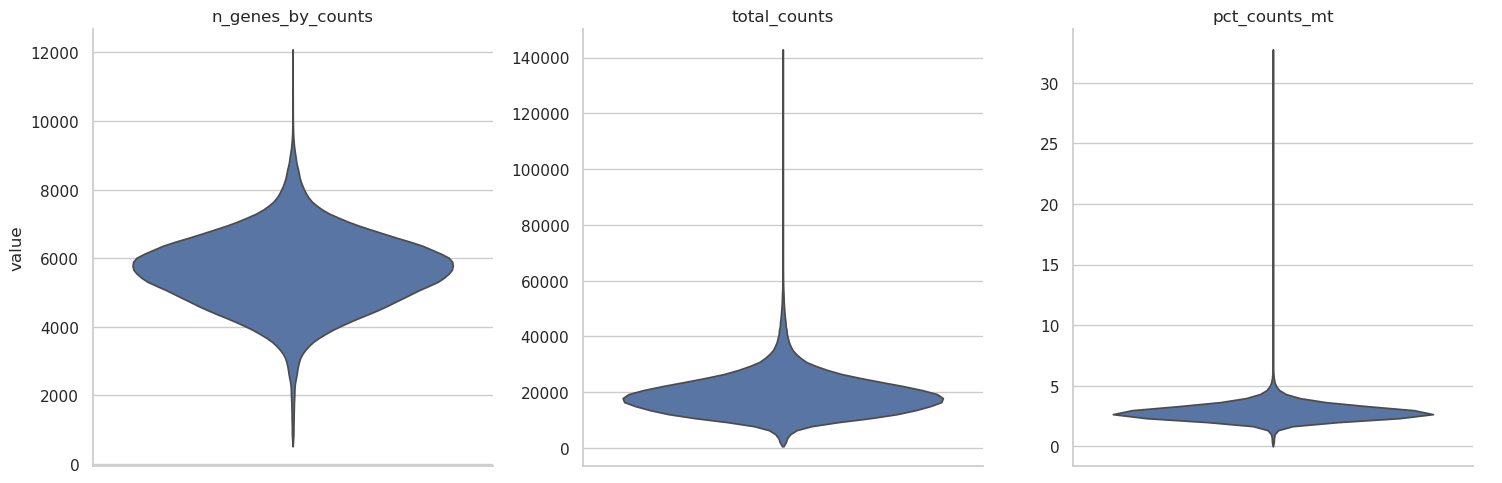

In [16]:
sc.pl.violin(
    adata_filt,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot=False,
    multi_panel=True,
)

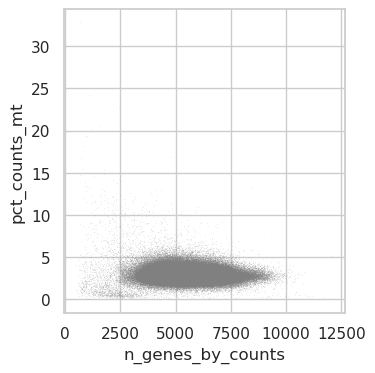

In [17]:
sc.pl.scatter(adata_filt, "n_genes_by_counts", "pct_counts_mt")

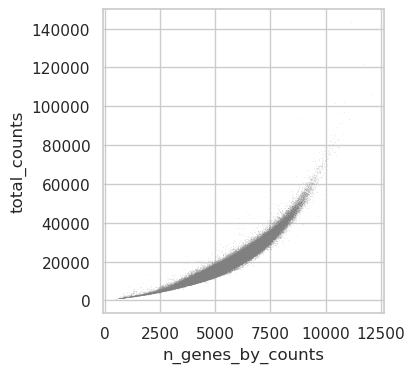

In [18]:
sc.pl.scatter(adata_filt, "n_genes_by_counts", "total_counts")

In [19]:
# Apply filtering criteria
adata_filt = adata_filt[
    (adata_filt.obs["n_genes_by_counts"] > p1_qlow) &
    (adata_filt.obs["n_genes_by_counts"] < p1_qhigh) &
    (adata_filt.obs["pct_counts_mt"] > p3_qlow) &
    (adata_filt.obs["pct_counts_mt"] < p3_qhigh)
].copy()

In [28]:
adata_filt

AnnData object with n_obs × n_vars = 51199 × 40774
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'

In [29]:
adata_filt.obs_names

Index(['AAACCAAAGATTACCG-1', 'AAACCAAAGCAACCGT-1', 'AAACCAAAGCATCGCG-1',
       'AAACCAAAGGCTGGTT-1', 'AAACCAGCAACTTTAG-1', 'AAACCATTCAATATCA-1',
       'AAACCATTCGGCTGCA-1', 'AAACCCATCATTGCTC-1', 'AAACCCCAGCTAGGAG-1',
       'AAACCCCAGGCCATAC-1',
       ...
       'GTTGTAAGTCCAGTGA-8', 'GTTGTAAGTCTAAATG-8', 'GTTGTATAGCAAGTTT-8',
       'GTTGTATAGGGTAGGC-8', 'GTTGTCCGTGGGGTCT-8', 'GTTGTCCGTGGGTTCA-8',
       'GTTGTCTTCGTATCAG-8', 'GTTGTGCAGCCGTTGG-8', 'GTTGTGCAGGCGGAGT-8',
       'GTTGTGGGTGGGATAA-8'],
      dtype='object', length=51199)

In [30]:
adata_filt.var_names

Index(['DDX11L2', 'MIR1302-2HG', 'FAM138A', 'ENSG00000290826', 'OR4F5',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599',
       ...
       'Non-Targeting-g101', 'Non-Targeting-g102', 'Non-Targeting-g103',
       'Non-Targeting-g104', 'Non-Targeting-g105', 'Non-Targeting-g106',
       'Non-Targeting-g107', 'Non-Targeting-g108', 'Non-Targeting-g109',
       'Non-Targeting-g110'],
      dtype='object', length=40774)

In [31]:
adata_filt.var

,gene_ids,feature_types,genome,pattern,read,sequence,target_gene_id,target_gene_name
DDX11L2,ENSG00000290825,Gene Expression,GRCh38,,,,,
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,,,,,
FAM138A,ENSG00000237613,Gene Expression,GRCh38,,,,,
ENSG00000290826,ENSG00000290826,Gene Expression,GRCh38,,,,,
OR4F5,ENSG00000186092,Gene Expression,GRCh38,,,,,
...,...,...,...,...,...,...,...,...
Non-Targeting-g106,Non-Targeting-g106,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,TGCCGTGGGTTTGCTGTAGC,Non-Targeting,Non-Targeting
Non-Targeting-g107,Non-Targeting-g107,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,ACAGTGGCCTTGTCTAGGGC,Non-Targeting,Non-Targeting
Non-Targeting-g108,Non-Targeting-g108,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,AGCGATCTGCGGCCCAGGAC,Non-Targeting,Non-Targeting
Non-Targeting-g109,Non-Targeting-g109,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,GTTCTTTGCGCCGTGCGCGC,Non-Targeting,Non-Targeting


### Separating gene expression and CRISPR guide capture

In [32]:
rna = adata_filt[:, adata_filt.var["feature_types"]=="Gene Expression"].copy()
crispr = adata_filt[:, adata_filt.var["feature_types"]=="CRISPR Guide Capture"].copy()

In [33]:
rna

AnnData object with n_obs × n_vars = 51199 × 38606
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'

In [34]:
crispr

AnnData object with n_obs × n_vars = 51199 × 2168
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'

## Exporting GEX 10X output matrix for use in R

In [35]:
with open('matrix_files/compass_GEX_iNeuron/barcodes.tsv', 'w') as f:
    for item in rna.obs_names:
        f.write(item + "\n")

In [36]:
with open('matrix_files/compass_GEX_iNeuron/features.tsv', 'w') as f:
    for item in ['\t'.join([x, x, "Gene Expression"]) for x in rna.var_names]:
        f.write(item + '\n')

In [37]:
io.mmwrite("matrix_files/compass_GEX_iNeuron/matrix.mtx", rna.X.T)

In [38]:
!ls matrix_files/compass_GEX_iNeuron/

barcodes.tsv  features.tsv  matrix.mtx


In [39]:
!gzip matrix_files/compass_GEX_iNeuron/*

## Exporting CRISPR Guide Capture 10X output matrix for use in R

In [41]:
with open('matrix_files/compass_CRISPR_iNeuron/barcodes.tsv', 'w') as f:
    for item in crispr.obs_names:
        f.write(item + "\n")

In [42]:
with open('matrix_files/compass_CRISPR_iNeuron/features.tsv', 'w') as f:
    for item in ['\t'.join([x, x, "Gene Expression"]) for x in crispr.var_names]:
        f.write(item + '\n')

In [43]:
io.mmwrite("matrix_files/compass_CRISPR_iNeuron/matrix.mtx", crispr.X.T)

In [44]:
!ls matrix_files/compass_CRISPR_iNeuron/

barcodes.tsv  features.tsv  matrix.mtx


In [45]:
!gzip matrix_files/compass_CRISPR_iNeuron/*